# How much can you save in Austin by adjusting your thermostat?
The goal of this project is to understand how much the weather influences our average energy bill. The data was first imported into a PostgreSQL database and will now be analysed using Python.

In [178]:
import psycopg2
import pandas as pd
import csv
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
try:
    connection = psycopg2.connect("dbname='austin_weather_energy' user='muriel' host='localhost' password='1'")
    print("connected to austin_weather_energy")
except:
    print("Unable to connect to the database")
# the cursor can help us execute SQL
cursor = connection.cursor()

connected to austin_weather_energy


# Exploring the Datasets
Before we do anything else, let's first look at which information is contained within the two tables.

In [179]:
def print_energy_values():
    cursor.execute("SELECT * from energy")
    colnames = [desc[0] for desc in cursor.description]
    print("Columns in database:")
    print(colnames)
    rows = cursor.fetchall()
    print("Values in database:")
    for row in rows[0:4]: #only print first 5 rows to avoid clutter
        print(" ", row)
    connection.commit()

def print_weather_values():
    cursor.execute("SELECT * from weather")
    colnames = [desc[0] for desc in cursor.description]
    print("Columns in database:")
    print(colnames)
    rows = cursor.fetchall()
    print("Values in database:")
    for row in rows[0:4]: #only print first 5 rows to avoid clutter
        print(" ", row)
    connection.commit()    
# print the first 5 values     
print_energy_values()
print_weather_values()

Columns in database:
['id', 'date', 'kwh', 'fuel_charge', 'average_bill']
Values in database:
  (1, datetime.date(2000, 1, 1), 820, 1.372, 54.26)
  (2, datetime.date(2000, 3, 1), 707, 1.372, 45.91)
  (3, datetime.date(2000, 5, 1), 838, 1.372, 61.68)
  (4, datetime.date(2000, 7, 1), 1442, 1.372, 117.2)
Columns in database:
['id', 'date', 'temphighf', 'tempavgf', 'templowf', 'dewpointhighf', 'dewpointavgf', 'dewpointlowf', 'humidityhighpercent', 'humidityavgpercent', 'humiditylowpercent', 'sealevelpressurehighinches', 'sealevelpressureavginches', 'sealevelpressurelowinches', 'visibilityhighmiles', 'visibilityavgmiles', 'visibilitylowmiles', 'windhighmph', 'windavgmph', 'windgustmph', 'precipitationsuminches', 'events']
Values in database:
  (1, datetime.date(2013, 12, 21), 74, 60, 45, 67, 49, 43, 93, 75, 57, 29.86, 29.68, 29.59, 10, 7, 2, 20, 4, 31, 0.46, 'Rain , Thunderstorm')
  (2, datetime.date(2013, 12, 23), 58, 45, 32, 31, 27, 23, 76, 52, 27, 30.56, 30.49, 30.41, 10, 10, 10, 8, 3, 1

Energy data contains four columns, including date and kwh (the average household energy consumption). Data is available bi-monthly. The first values are in 2000

Weather data has many columns, including date and temperature data. One datapoint seems to be available for every second day. The first collected values are in 2013, which will narrow the overlap with the energy data.

In [180]:
print("energy timeline")
sql = "SELECT min(date) FROM energy"
cursor.execute(sql)
print(cursor.fetchall())

sql = "SELECT max(date) FROM energy"
cursor.execute(sql)
print(cursor.fetchall())


print("weather min/max")
sql = "SELECT min(date) FROM weather"
cursor.execute(sql)
print(cursor.fetchall())

sql = "SELECT max(date) FROM weather"
cursor.execute(sql)
print(cursor.fetchall())

energy timeline
[(datetime.date(2000, 1, 1),)]
[(datetime.date(2016, 3, 1),)]
weather min/max
[(datetime.date(2013, 12, 21),)]
[(datetime.date(2017, 7, 31),)]


So we can use the overlap between 2013 and 2016 for analysis.


# Visualizing the data
Next, let's have a look at energy consuption.

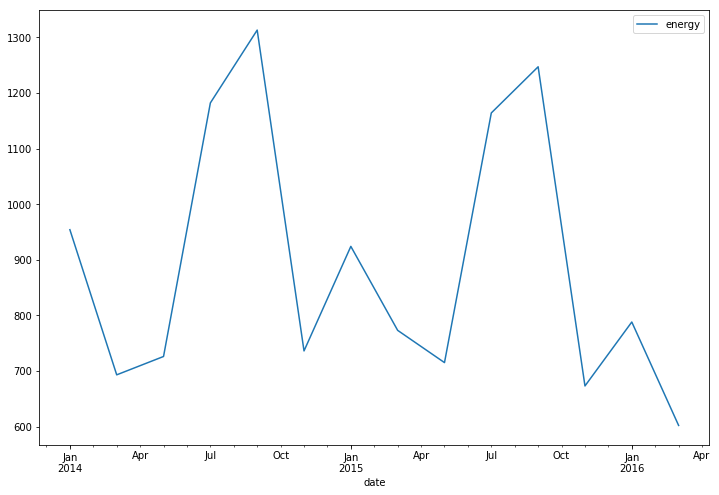

In [181]:
cursor.execute("SELECT date, kwh, average_bill FROM energy WHERE date between '2013-12-20' and '2016-03-02'")
rows = cursor.fetchall()

df = pd.DataFrame(rows, columns=['date','energy','bill'])
df['date'] = pd.to_datetime(df['date'])
df.plot(x='date',y='energy', figsize=(12,8))
connection.commit()

We clearly observe seasonality in the data, with a strong increase in energy consumption in the summer when people cool down their houses. A light increase is also observed in the winter, with the lowest energy consumption in the spring and autumn.

        date  energy    bill
0 2014-01-01     954   93.72
1 2014-03-01     693   65.61
2 2014-05-01     726   69.18
3 2014-07-01    1182  144.15
4 2014-09-01    1313  162.84


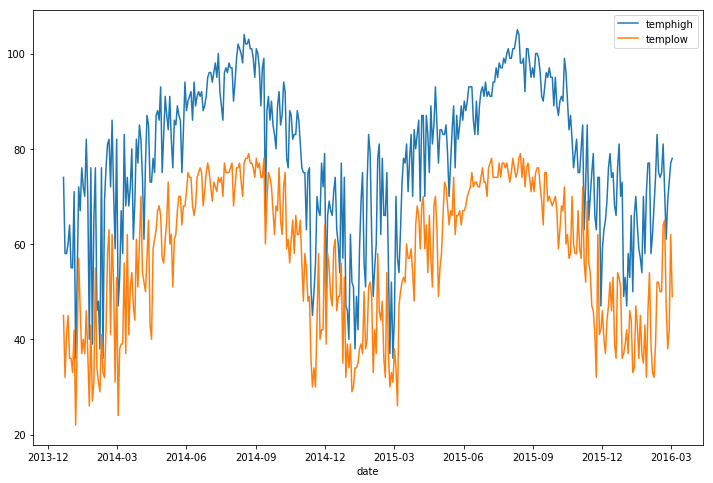

In [182]:
cursor.execute("SELECT date, temphighf, templowf FROM weather WHERE date between '2013-12-20' and '2016-03-02'")
rows = cursor.fetchall()
connection.commit()

df2 = pd.DataFrame(rows, columns=['date','temphigh', 'templow'])
print(df.head())
plt = df2.plot(x='date',figsize=(12,8))
df2['date'] = pd.to_datetime(df2['date'])


# Mathematical modeling for energy cost prediction
It would be logical to assume that the energy consuption is determined by:
1. Some base value (non-temperature dependant)
2. Heating (dependent on the amount of days below a certain minimum temperature)
3. Cooling (dependent on the amount of days above a certain maximum temperature)

We will need to convert the data to the same time interval. Energy consumption is only
available on a bi-monthly basis, wheras temperatures are given daily. We will create a 
new dataframe which contains the information we need to calculate (and predict) energy
consumption based on the weather.

## Create a dataframe for actual & predicted costs

In [188]:
# let's create a function which will calculate the monthly energy bill for
# an array of daily maximum and minimum temperature values:

def create_df(T_heat_to, T_cool_to):
    """This function creates a dataframe which contains five columns:
    1. The year
    2. The month
    3. The sum of the daily cheating (where heating is defined as the difference 
        between daily minimum temperature and the thermostat "heat to" setting)
    4. The sum of the daily heating (where heating is defined as the difference 
        between the daily maximum and the thermostat "cool to" setting )
        
    Two input variabls need to be specified: The thermostat heat to value (T_heat_to)
    and the thermostat cool to value (T_cool_to)"""

    # create empty arrays
    c_year = []
    c_month = []
    c_heating = []
    c_cooling = []
    c_cost = []

    def calculate_monthly_bill(t_max,t_min, T_heat_to, T_cool_to):
        """This function sums up the daily heating and cooling values and takes four
        input variables: 
        1. t_max (array) daily maximum temperatures for the month
        2. t_min (array) daily minimum temperatures for the month
        3. T_heat_to (numerical) thermostat heat to value
        4. T_cool_to (numerical) thermostat cool to value
        Two values are returned:
        total_heating, which is the sum of the difference between the minimum 
        daily temperature and the thermostat "heat to" value for the month
        total_cooling, which is the sum of the difference between the maximum 
        daily temperature and the thermostat "cool to" value for the month""" 
        total_heating = 0
        total_cooling = 0
        for tmax, tmin in zip(t_max, t_min):
            #print(tmax,tmin)
            if tmin < T_heat_to:
                heat = T_heat_to - tmin
                #print("heat %r degrees" %heat)
                total_heating += heat
            if tmax > T_cool_to:
                cool = tmax - T_cool_to
                #print("cool %r degrees" %cool)
                total_cooling += cool
        return (total_heating, total_cooling)

# the goal of this for loop is to create the columns for the dataframe to be returned from three
# sources: 
# 1. temperatures are imported via SQL from the weather table
# 2. the energy bill from  the energy table in the austin_weather_energy database
# 3. monthly heating and cooling is calculated from daily values using the calculate_monthly_bill function
    for year in range(2014,2016):
        for month in range(1,13,2):
            c_year.append(year)
            c_month.append(month)       
            sql = """SELECT date, temphighf, templowf FROM weather WHERE EXTRACT(MONTH FROM date) = %d
            AND EXTRACT(YEAR FROM date) = %d""" %(month,year)
            #print(sql)
            cursor.execute(sql)
            rows = cursor.fetchall()
            #print(rows)
            temphigh = [row[1] for row in rows]
            templow = [row[2] for row in rows]        
            (heating,cooling) = calculate_monthly_bill(temphigh,templow, T_heat_to, T_cool_to)
            c_heating.append(heating)
            c_cooling.append(cooling)
            sql = """SELECT average_bill FROM energy WHERE EXTRACT(MONTH FROM date) = %d
            AND EXTRACT(YEAR FROM date) = %d""" %(month,year)
            cursor.execute(sql)
            rows = cursor.fetchall()
            try:
                energy = rows[0][0]
            except IndexError:
                energy = 'NaN'
            c_cost.append(energy)

    my_data = zip(c_year,c_month,c_heating,c_cooling,c_cost)

    df3 = pd.DataFrame()
    df3['year'] = c_year
    df3['month'] = c_month
    df3['heating'] = c_heating
    df3['cooling'] = c_cooling
    df3['cost'] = c_cost
    return df3


## Minimize error using SciPy.optimize

In [189]:
def calculate_error(x):
    """the goal of this function is to calculate the error between predicted and 
    actual energy cost based on five input variables:
    1. the base load (non-weather dependant) cost x[0]
    2. the multiplier for heating x[1]
    3. the multiplier for cooling x[2]
    4. the thermostat "heat to" value x[3]
    5. the thermostat "cool to" value x[4]
    the function returns the sum of the error between the predicted and actual energy cost""" 
    error = 0
    a = x[0]
    b = x[1]
    c = x[2]
    T_heat_to = x[3]
    T_cool_to = x[4]
    this_df = create_df(T_heat_to, T_cool_to)
    for index, row in this_df.iterrows():
        heating = row['heating']
        cooling = row['cooling']
        cost = row['cost']
        cost_pred = a + b*heating + c*cooling
        # print("Predicted: %r and Actual %r" %(cost_pred, cost))
        error += abs(cost-cost_pred)
    return error

#initialize the values
x0 = [1,1,1,72,78]
y = calculate_error(x0)
from scipy.optimize import minimize

res = minimize(calculate_error, x0)
res.x

array([16.70513311,  0.17414937,  0.43484171, 65.99999999, 76.03270649])

This result shows us that: 
1. the base cost (none-energy dependant) of energy is $16 per month
2. the multiplier for heating is about 17 cents per degree per day
3. the multiplier for cooling is about 43 cents per degree per day
4. In Austin, people on average set their thermostats to heat to 66 degF
5. In Austin, people on average set their thermostats to cool to 76 degF

## Model validation
Let's do a quick check to see how accurate our prediction is based on the available data:

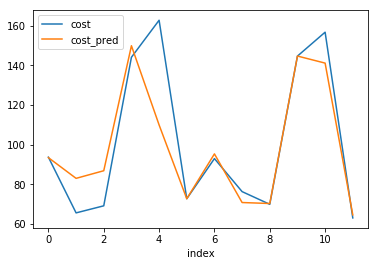

In [192]:
a = res.x[0]
b = res.x[1]
c = res.x[2]
T_heat_to = res.x[3]
T_cool_to = res.x[4]
df3 = create_df(T_heat_to, T_cool_to)
df3['cost_pred'] = a + df3['heating']*b + df3['cooling']*c
ax1 = df3.reset_index().plot(kind='line', x='index', y = 'cost')
ax2 = df3.reset_index().plot(kind='line', x='index', y = 'cost_pred', ax=ax1)

The results are okay, not great. For the first year, energy costs in the winter are over-estimated and under-estimated in July. Regardless, the model seems to give a pretty accurate prediction of energy costs based on the weather only.

# Conclusion
Now that we have a model which predicts energy costs based on thermostat settings, we can use this model to predict the energy savings for heating  / cooling one degree less.


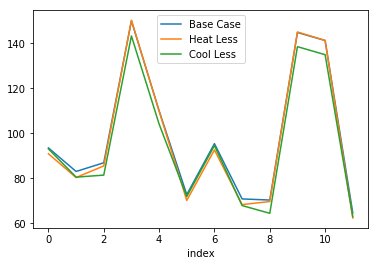

In [193]:
#create a new dataframe with price predictions to heat to 65 instead of 66 degrees
T_heat_to = 65
T_cool_to = 76
df_heat_less = create_df(T_heat_to, T_cool_to)
df_heat_less['cost_pred'] = a + df_heat_less['heating']*b + df_heat_less['cooling']*c

#create a new dataframe with price predictions to cool to 77 instead of 76 degrees
T_heat_to = 66
T_cool_to = 77
df_cool_less = create_df(T_heat_to, T_cool_to)
df_cool_less['cost_pred'] = a + df_cool_less['heating']*b + df_cool_less['cooling']*c

ax1 = df3.reset_index().plot(kind='line', x='index', y = 'cost_pred')
ax2 = df_heat_less.reset_index().plot(kind='line',x='index', y = 'cost_pred', ax=ax1)
ax3 = df_cool_less.reset_index().plot(kind='line',x='index', y = 'cost_pred', ax=ax1)
ax1.legend(['Base Case','Heat Less','Cool Less'])

In [194]:
heat_less_savings = df3.cost_pred - df_heat_less.cost_pred
cool_less_savings = df3.cost_pred - df_cool_less.cost_pred
print("You will save $%d per year by setting your thermostat to heat to 65 instead of 66 degrees... " %(sum(heat_less_savings)/2))
print("You will save $%d per year by setting your thermostat to cool to 77 instead of 76 degrees... " %(sum(cool_less_savings)/2))

You will save $8 per year by setting your thermostat to heat to 65 instead of 66 degrees... 
You will save $22 per year by setting your thermostat to cool to 77 instead of 76 degrees... 


# In total, you can save $30 a year by adjusting your thermostat one degree. Such win!